# OLIMPÍADAS

Envolvido pelo clima olímpico, investiguei informações sobre as Olimpíadas, a fim de obter curiosidades sobre o evento. Por exemplo, quais esportes foram disputados nas primeiras edições que me chamaram atenção, quais os maiores campeões olímpicos (países e atletas), etc. Dados tirados de https://www.kaggle.com/datasets/josephcheng123456/olympic-historical-dataset-from-olympediaorg?resource=download

____________________________________________________________________________________________________________________

#### Importação e visualização dos dados

In [2]:
import os
import pandas as pd
import pandas as pd
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData
from sqlalchemy.sql import text
import numpy as np

In [3]:
# Listar todos os csv com informações olímpicas:
for file in os.listdir('.'):
    if file.endswith('.csv'):
        df=pd.read_csv(os.path.join(pasta,file),encoding='utf-8')
        print(f'\n>> {file}: {df.columns.values}')

#### Importar os arquivos:

In [4]:
# Infos about each Olympic edition: year, city, date
csv_file = r'C:\Users\bserpellone\Desktop\Python\github\olimpíada\Olympics_Games.csv'
df = pd.read_csv(csv_file)
engine = create_engine('sqlite:///olympics_games.db')
df.to_sql('olympics_editions', con=engine, index=False, if_exists='replace')

# Country acronyms
csv_file = r'C:\Users\bserpellone\Desktop\Python\github\olimpíada\Olympics_Country.csv'
df = pd.read_csv(csv_file)
engine = create_engine('sqlite:///olympics_games.db')
df.to_sql('countries', con=engine, index=False, if_exists='replace')

# Athletes bio, id, name, sex, height, weight, country
csv_file = r'C:\Users\bserpellone\Desktop\Python\github\olimpíada\Olympic_Athlete_Bio.csv'
df = pd.read_csv(csv_file)
engine = create_engine('sqlite:///olympics_games.db')
df.to_sql('athletes_bio', con=engine, index=False, if_exists='replace')

# Results of each sport with edition, country, result, athlete
csv_file = r'C:\Users\bserpellone\Desktop\Python\github\olimpíada\Olympic_Athlete_Event_Results.csv'
df = pd.read_csv(csv_file)
engine = create_engine('sqlite:///olympics_games.db')
df.to_sql('athletes_results', con=engine, index=False, if_exists='replace')

# Country medal tally per edition
csv_file = r'C:\Users\bserpellone\Desktop\Python\github\olimpíada\Olympic_Games_Medal_Tally.csv'
df = pd.read_csv(csv_file)
engine = create_engine('sqlite:///olympics_games.db')
df.to_sql('country_medals_tally', con=engine, index=False, if_exists='replace')

# Events/sports descriptions
csv_file = r'C:\Users\bserpellone\Desktop\Python\github\olimpíada\Olympic_Results.csv'
df = pd.read_csv(csv_file)
engine = create_engine('sqlite:///olympics_games.db')
df.to_sql('sports_descriptions', con=engine, index=False, if_exists='replace')

7394

## 1. EDIÇÕES OLÍMPICAS

#### Quantas edições tiveram de Olimpíadas de Verão até hoje, contando com a edição de Paris 2024?

In [5]:
query = """
    SELECT COUNT(*) AS Edições
    FROM olympics_editions 
    WHERE EDITION LIKE '%Summer%'
        AND CAST(SUBSTR(EDITION, 1, 4) AS INT) <= 2024
    """
df_query = pd.read_sql(query,con=engine)
df_query

,Edições
0,33


#### Há cidades que já sediaram a Olimpíada mais de uma vez?

In [6]:
query = """
    SELECT CITY, COUNT(*) as headquarters
    FROM olympics_editions 
    WHERE EDITION LIKE '%Summer%'
        AND CAST(SUBSTR(EDITION, 1, 4) AS INT) <= 2024
    GROUP BY CITY
    HAVING COUNT(*) > 1
    ORDER BY COUNT(*) DESC
    """
df_query = pd.read_sql(query,con=engine)
df_query

,city,headquarters
0,London,4
1,Paris,3
2,Tokyo,2
3,Los Angeles,2
4,Helsinki,2
5,Berlin,2
6,Athina,2


#### Quais edições esses países sediaram?

In [7]:
query = """
    SELECT CITY, YEAR 
    FROM olympics_editions 
    WHERE EDITION LIKE '%Summer%'
        AND CAST(SUBSTR(EDITION, 1, 4) AS INT) <= 2024
        AND CITY IN ('London', 'Paris',
                    'Tokyo', 'Los Angeles',
                    'Helsinki', 'Berlin',
                    'Athina')
    ORDER BY CITY
    """
df_query = pd.read_sql(query,con=engine)
df_query

,city,year
0,Athina,1896
1,Athina,2004
2,Berlin,1916
3,Berlin,1936
4,Helsinki,1940
5,Helsinki,1952
6,London,1908
7,London,1944
8,London,1948
9,London,2012


#### Formatação da coluna data

In [8]:
# Conectar ao banco de dados
engine = create_engine('sqlite:///olympics_games.db')

# Carregar dados em um DataFrame
df = pd.read_sql_table('olympics_editions', con=engine)

# Função para formatar a data de competição
def format_competition_date(date_str, year):
    month_map = {
        'january': '01', 'february': '02', 'march': '03', 'april': '04',
        'may': '05', 'june': '06', 'july': '07', 'august': '08',
        'september': '09', 'october': '10', 'november': '11', 'december': '12'
    }
    
    if ' – ' in date_str:
        before_hyphen, after_hyphen = date_str.split(' – ')
        before_parts = before_hyphen.strip().split()
        after_parts = after_hyphen.strip().split()
        
        try:
            # Formatar a data de início
            if len(before_parts) == 1 and before_parts[0].isdigit():
                day_start = before_parts[0].zfill(2)
                month_start = month_map[after_parts[1].lower()]
            else:
                day_start = before_parts[0].zfill(2)
                month_start = month_map[before_parts[1].lower()]

            # Formatar a data de término
            day_end = after_parts[0].zfill(2)
            month_end = month_map[after_parts[1].lower()]

            start_date = f"{year}-{month_start}-{day_start}"
            end_date = f"{year}-{month_end}-{day_end}"
            return start_date, end_date
        except (IndexError, KeyError) as e:
            print(f"Error parsing date: {date_str} - {str(e)}")
            return None, None
    return None, None

# Função para padronizar datas
def standardize_date(date_str, year):
    try:
        return pd.to_datetime(date_str, format='%d %B', errors='coerce').replace(year=year).strftime('%Y-%m-%d') if pd.notna(date_str) else None
    except ValueError:
        return None

# Aplicar formatação às colunas start_date e end_date
df['formatted_start_date'] = df.apply(lambda row: standardize_date(row['start_date'], row['year']), axis=1)
df['formatted_end_date'] = df.apply(lambda row: standardize_date(row['end_date'], row['year']), axis=1)

# Usar competition_date como fallback se start_date ou end_date estiverem ausentes
df['formatted_start_date'], df['formatted_end_date'] = zip(*df.apply(
    lambda row: (row['formatted_start_date'], row['formatted_end_date']) 
    if pd.notna(row['formatted_start_date']) and pd.notna(row['formatted_end_date']) 
    else format_competition_date(row['competition_date'], row['year']),
    axis=1
))

# Atualizar a tabela no banco de dados
df.to_sql('olympics_editions', con=engine, index=False, if_exists='replace')

64

#### Qual a média de duração dos jogos Olímpicos?

In [9]:
# O SQLite não tem a função DATEDIFF, uma semelhante é JULANDAY:
query = """
    SELECT  
        AVG(JULIANDAY(formatted_end_date) - JULIANDAY(formatted_start_date)) AS [duration (days)]
    FROM 
        olympics_editions 
    WHERE 
        EDITION LIKE '%Summer%'
        AND CAST(SUBSTR(EDITION, 1, 4) AS INT) <= 2024
        AND formatted_start_date != 'None'
        AND formatted_end_date != 'None'
    """
df_query = pd.read_sql(query,con=engine)
df_query

,duration (days)
0,25.034483


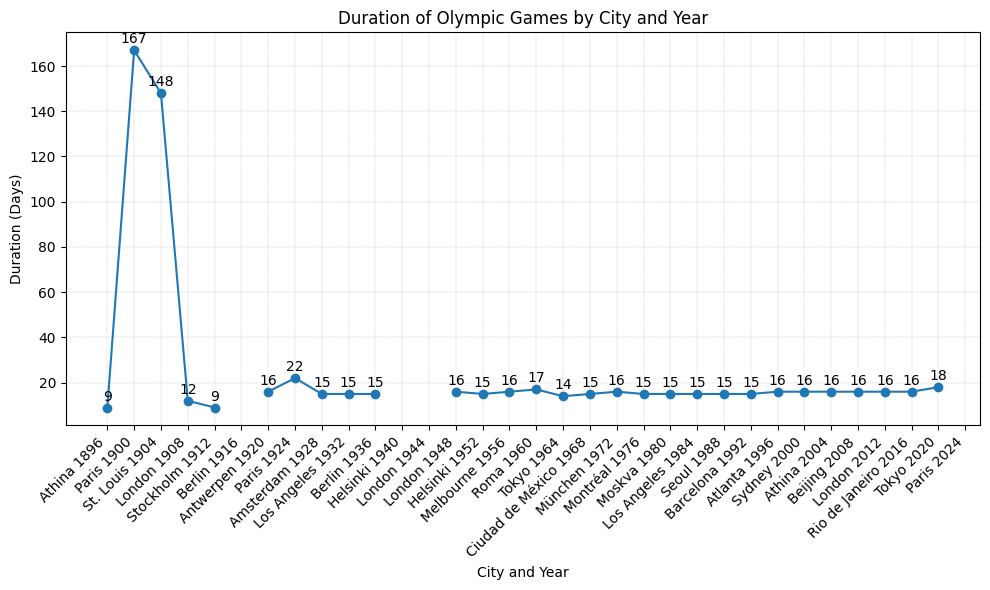

In [10]:
import matplotlib.pyplot as plt

# Consultar os dados
query = """
    SELECT  
        CITY, 
        YEAR, 
        START_DATE,
        END_DATE,
        strftime('%Y-%m-%d', START_DATE) AS formatted_start_date,
        strftime('%Y-%m-%d', END_DATE) AS formatted_end_date,
        JULIANDAY(formatted_end_date) - JULIANDAY(formatted_start_date) AS Duração
    FROM 
        olympics_editions 
    WHERE 
        EDITION LIKE '%Summer%'
        AND CAST(SUBSTR(EDITION, 1, 4) AS INT) <= 2024
"""
df_query = pd.read_sql(query, con=engine)

# Criar a coluna para o eixo X
df_query['City_Year'] = df_query['city'] + ' ' + df_query['year'].astype(str)

# Plotar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(df_query['City_Year'], df_query['Duração'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('City and Year')
plt.ylabel('Duration (Days)')
plt.title('Duration of Olympic Games by City and Year')
plt.grid(linestyle='--', lw=0.25)
for i, row in df_query.iterrows():
    if not np.isnan(row['Duração']):
        plt.annotate(
            f"{int(row['Duração'])}", 
            (row['City_Year'], row['Duração']),
            textcoords="offset points", 
            xytext=(0,5), 
            ha='center'
        )
plt.tight_layout()
plt.show()

##### Após 1948, as Olimpíadas passaram a durar, em média, 17 dias

##### Conclusão: A edição de Londres 1908 foi a mais longa da história, com 6 meses

## 2. EDIÇÃO DE ATENAS 1896

#### Quais provas foram disputados na primeira edição?

In [11]:
query = """
    SELECT  
        DISTINCT
            o.CITY, 
            o.YEAR, 
            r.SPORT
    FROM 
        athletes_results r
            INNER JOIN olympics_editions o
                ON r.edition_id = o.edition_id
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1896
    """
df_query = pd.read_sql(query,con=engine)
df_query

,city,year,sport
0,Athina,1896,Artistic Gymnastics
1,Athina,1896,Athletics
2,Athina,1896,Cycling Road
3,Athina,1896,Cycling Track
4,Athina,1896,Fencing
5,Athina,1896,Shooting
6,Athina,1896,Swimming
7,Athina,1896,Tennis
8,Athina,1896,Weightlifting
9,Athina,1896,Wrestling


43 provas foram disputadas, com 129 medalhas distribuídas

### Como foi o quadro de medalhas (top 5)?

In [30]:
query = """
    SELECT  
        DISTINCT
            t.COUNTRY,
            t.GOLD,
            t.SILVER,
            t.BRONZE,
            t.TOTAL
    FROM 
        olympics_editions o
        INNER JOIN country_medals_tally t
            ON t.edition_id = o.edition_id
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1896
    ORDER BY t.GOLD DESC
    """
df_query = pd.read_sql(query,con=engine)
df_query

,country,gold,silver,bronze,total
0,United States,11,7,2,20
1,Greece,10,18,19,47
2,Germany,6,5,2,13
3,France,5,4,2,11
4,Australia,2,0,0,2
5,Austria,2,1,2,5
6,Great Britain,2,3,2,7
7,Hungary,2,1,3,6
8,Denmark,1,2,3,6
9,Mixed team,1,0,1,2


Apenas 10 países disputaram a primeira Olimpíada

### Quais atletas mais ganharam ouro/medalhas?

In [58]:
query = """
WITH qty_medals_1 AS (
    SELECT  
        r.ATHLETE,
        b.SEX,
        c.COUNTRY,
        COUNT(r.MEDAL) as num_medals
    FROM 
        athletes_results r
        INNER JOIN olympics_editions o
            ON r.edition_id = o.edition_id
        INNER JOIN athletes_bio b
            ON b.athlete_id = r.athlete_id
        INNER JOIN countries c
            ON c.noc = r.country_noc
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1896
        AND r.MEDAL != 'None'
    GROUP BY
        r.ATHLETE, b.SEX, c.COUNTRY
)

SELECT 
    r.ATHLETE,
    b.SEX,
    c.COUNTRY,
    r.SPORT,
    COUNT(r.MEDAL) as qty_golds,
    m.num_medals as qty_medals
FROM 
    athletes_results r
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
    INNER JOIN athletes_bio b
        ON b.athlete_id = r.athlete_id
    INNER JOIN countries c
        ON c.noc = r.country_noc
    INNER JOIN qty_medals_1 m
        ON m.ATHLETE = r.ATHLETE
            AND c.COUNTRY = m.COUNTRY
WHERE 
    o.EDITION LIKE '%Summer%'
    AND o.YEAR = 1896
    AND r.MEDAL = 'Gold'
GROUP BY
    r.ATHLETE, b.SEX, c.COUNTRY, r.SPORT, m.num_medals
ORDER BY qty_golds DESC
LIMIT 5;
"""
df_query = pd.read_sql(query,con=engine)
df_query

,athlete,sex,country,sport,qty_golds,qty_medals
0,Alfred Flatow,Male,Germany,Artistic Gymnastics,3,4
1,Carl Schuhmann,Male,Germany,Artistic Gymnastics,3,4
2,Hermann Weingärtner,Male,Germany,Artistic Gymnastics,3,6
3,Paul Masson,Male,France,Cycling Track,3,3
4,Alfréd Hajós,Male,Hungary,Swimming,2,2


#### Quais esportes foram incluídos na segunda edição da Olimpíada de Paris, em 1900?

In [72]:
query = """
WITH sports_athens AS (
    SELECT  
        R.SPORT
    FROM 
        athletes_results r
        INNER JOIN olympics_editions o
            ON r.edition_id = o.edition_id
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1896
    GROUP BY
        r.SPORT
)

    SELECT 
        R.SPORT
    FROM 
        athletes_results r
            LEFT JOIN olympics_editions o
                ON r.edition_id = o.edition_id
            LEFT JOIN sports_athens a
                ON a.SPORT = r.SPORT

    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1900
        AND a.SPORT IS NULL
    GROUP BY
        r.SPORT
"""
df_query = pd.read_sql(query,con=engine)
df_query

,sport
0,Archery
1,Automobile Racing
2,Ballooning
3,Basque pelota
4,Boules
5,Cricket
6,Croquet
7,Equestrian Dressage
8,Equestrian Driving
9,Equestrian Jumping


##### Alguns desses esportes foram não oficiais. Nessa época, o regulamento esportivo não era tão elaborado quanto hoje, o que permitia a inclusão de esportes informais.
##### Pesquisando sobre o balonismo (esporte de soltar balões), foi um esporte de demonstração, pelo balonismo despertar interesse na época por ser uma tecnologia fascinante

#### Quais as modalidades disputadas desses esportes fora do convencional?

In [19]:
query = """
WITH sports_athens AS (
    SELECT  
        R.SPORT, R.EVENT
    FROM 
        athletes_results r
        INNER JOIN olympics_editions o
            ON r.edition_id = o.edition_id
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1896
    GROUP BY
        r.SPORT, r.EVENT
)

    SELECT 
        R.SPORT, r.EVENT
    FROM 
        athletes_results r
            LEFT JOIN olympics_editions o
                ON r.edition_id = o.edition_id
            LEFT JOIN sports_athens a
                ON a.SPORT = r.SPORT

    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1900
        AND a.SPORT IS NULL
    GROUP BY
        r.SPORT
"""
df_query = pd.read_sql(query,con=engine)
pd.options.display.max_colwidth = 500
df_query

,sport,event
0,Archery,"Au Chapelet, 33 metres, Men"
1,Automobile Racing,"Paris-Toulouse-Paris, Cars, Men"
2,Ballooning,"Ascension report, Combined, Open"
3,Basque pelota,"Two-Man Teams With Cesta, Men"
4,Boules,"Jeu de berges, Quartets, Men"
5,Cricket,"Cricket, Men"
6,Croquet,"Doubles, Open"
7,Equestrian Dressage,"Hacks and Hunter Combined, Open"
8,Equestrian Driving,"Four-In-Hand Competition, Open"
9,Equestrian Jumping,"High Jump, Open"


#### Quais esportes disputados em 1920 não foram disputados em Tóquio 2020?

In [78]:
query = """
WITH sports_athens AS (
    SELECT  
        R.SPORT
    FROM 
        athletes_results r
        INNER JOIN olympics_editions o
            ON r.edition_id = o.edition_id
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 2020
    GROUP BY
        r.SPORT
)

    SELECT 
        R.SPORT
    FROM 
        athletes_results r
            LEFT JOIN olympics_editions o
                ON r.edition_id = o.edition_id
            LEFT JOIN sports_athens a
                ON a.SPORT = r.SPORT
    WHERE 
        o.EDITION LIKE '%Summer%'
        AND o.YEAR = 1920
        AND a.SPORT IS NULL
    GROUP BY
        r.SPORT
"""
df_query = pd.read_sql(query,con=engine)
df_query

,sport
0,Art Competitions
1,Equestrian Vaulting
2,Figure Skating
3,Ice Hockey
4,Korfball
5,Polo
6,Rugby
7,Tug-Of-War


____________________________________________________________________________________________________________________

## 2. DESEMPENHO

#### 2.1 POR PAÍSES

#### Quais países mais ganharam medalhas acumuladas até a edição de Tóquio 2020?

In [12]:
query = """
    WITH TotalMedals AS (
        SELECT SUM(TOTAL) AS Total
        FROM country_medals_tally
        WHERE EDITION LIKE '%Summer%'
          AND YEAR <= 2024
    )
    SELECT  
        COUNTRY, 
        SUM(TOTAL) AS medals,
        ROUND(SUM(TOTAL) * 1.0 / (SELECT Total FROM TotalMedals),2) AS proportion
    FROM 
        country_medals_tally 
    WHERE 
        EDITION LIKE '%Summer%'
        AND YEAR <= 2024
    GROUP BY COUNTRY
    ORDER BY medals DESC
    LIMIT 10
"""
df_query = pd.read_sql(query, con=engine)
df_query

,country,medals,proportion
0,United States,2655,0.16
1,Soviet Union,1010,0.06
2,Great Britain,927,0.05
3,Germany,791,0.05
4,France,773,0.05
5,People's Republic of China,636,0.04
6,Italy,629,0.04
7,Australia,541,0.03
8,Hungary,515,0.03
9,Sweden,504,0.03


#### E de ouro?

In [13]:
query = """
    WITH TotalMedals AS (
        SELECT SUM(GOLD) AS Total
        FROM country_medals_tally
        WHERE EDITION LIKE '%Summer%'
          AND YEAR <= 2024
    )
    SELECT  
        COUNTRY, 
        SUM(GOLD) AS gold,
        ROUND(SUM(GOLD) * 1.0 / (SELECT Total FROM TotalMedals),2) AS proportion
    FROM 
        country_medals_tally 
    WHERE 
        EDITION LIKE '%Summer%'
        AND YEAR <= 2024
    GROUP BY COUNTRY
    ORDER BY GOLD DESC
    LIMIT 10
"""
df_query = pd.read_sql(query, con=engine)
df_query

,country,gold,proportion
0,United States,1070,0.19
1,Soviet Union,395,0.07
2,Great Britain,291,0.05
3,People's Republic of China,263,0.05
4,Germany,237,0.04
5,France,231,0.04
6,Italy,222,0.04
7,Hungary,182,0.03
8,Japan,169,0.03
9,Australia,162,0.03


### Quais países terminaram a Olimpíada com mais ouros, considerando todas as edições?

In [17]:
query = """
    WITH ranking_paises_mais_ouros AS (
        SELECT YEAR, COUNTRY, GOLD, ROW_NUMBER() OVER(PARTITION BY EDITION_ID ORDER BY GOLD DESC) AS RANKING
        FROM country_medals_tally
        WHERE EDITION LIKE '%Summer%'
          AND YEAR <= 2024
    )
    
    SELECT  
        O.COUNTRY, COUNT(O.RANKING) AS biggest_champions
    FROM ranking_paises_mais_ouros O
    WHERE O.RANKING = 1
    GROUP BY O.COUNTRY
    ORDER BY COUNT(O.RANKING) DESC
"""
df_query = pd.read_sql(query, con=engine)
df_query

,COUNTRY,biggest_champions
0,United States,18
1,Soviet Union,6
2,Unified Team,1
3,People's Republic of China,1
4,Great Britain,1
5,Germany,1
6,France,1


#### Qual país foi o maior ganhador de ouro em cada edição?

In [15]:
query = """
    WITH ranking_paises_mais_ouros AS (
        SELECT YEAR, COUNTRY, GOLD, ROW_NUMBER() OVER(PARTITION BY EDITION_ID ORDER BY GOLD DESC) AS RANKING
        FROM country_medals_tally
        WHERE EDITION LIKE '%Summer%'
          AND YEAR <= 2024
    )
    
    SELECT  
        O.COUNTRY, O.YEAR, O.RANKING AS biggest_champions
    FROM ranking_paises_mais_ouros O
    WHERE O.RANKING = 1
"""
df_query = pd.read_sql(query, con=engine)
df_query

,COUNTRY,YEAR,biggest_champions
0,United States,1896,1
1,France,1900,1
2,United States,1904,1
3,Great Britain,1908,1
4,United States,1912,1
5,United States,1920,1
6,United States,1924,1
7,United States,1928,1
8,United States,1932,1
9,Germany,1936,1


#### Quais as 5 edições com maior proporção de medalhas de ouro por um país?

In [14]:
query = """
    WITH EDIÇÃO_TOTAL AS (
        SELECT  
            EDITION,
            YEAR,
            SUM(GOLD) AS TOTAL_GOLD
        FROM 
            country_medals_tally
        WHERE 
            EDITION LIKE '%Summer%'
            AND YEAR <= 2024
        GROUP BY 
            EDITION, YEAR
    ),
    PROPORÇÕES AS (
        SELECT  
            TALLY.COUNTRY,
            TALLY.EDITION,
            TALLY.YEAR,
            SUM(TALLY.GOLD) AS GOLD_TOTAL,
            TOTAL.TOTAL_GOLD,
            (SUM(TALLY.GOLD) * 1.0 / TOTAL.TOTAL_GOLD) AS PROPORTION
        FROM 
            country_medals_tally TALLY
        JOIN 
            EDIÇÃO_TOTAL TOTAL
        ON 
            TALLY.EDITION = TOTAL.EDITION
            AND TALLY.YEAR = TOTAL.YEAR
        WHERE 
            TALLY.EDITION LIKE '%Summer%'
            AND TALLY.YEAR <= 2024
        GROUP BY 
            TALLY.COUNTRY, TALLY.EDITION, TALLY.YEAR, TOTAL.TOTAL_GOLD
    ),
    MELHORES_PROPORÇÕES AS (
        SELECT
            EDITION,
            YEAR,
            COUNTRY,
            GOLD_TOTAL,
            TOTAL_GOLD,
            PROPORTION,
            ROW_NUMBER() OVER(PARTITION BY EDITION, YEAR ORDER BY PROPORTION DESC) AS RANK
        FROM 
            PROPORÇÕES
    )
    SELECT  
        COUNTRY,
        EDITION,
        YEAR,
        GOLD_TOTAL AS MEDALHAS_DE_OURO,
        TOTAL_GOLD AS TOTAL_DE_OUROS_EDICAO,
        PROPORTION
    FROM 
        MELHORES_PROPORÇÕES
    WHERE 
        RANK = 1
    ORDER BY 
        PROPORTION DESC
    LIMIT 5;
"""
df_query = pd.read_sql(query, con=engine)
df_query

,COUNTRY,EDITION,YEAR,MEDALHAS_DE_OURO,TOTAL_DE_OUROS_EDICAO,PROPORTION
0,United States,1904 Summer Olympics,1904,80,97,0.824742
1,Great Britain,1908 Summer Olympics,1908,56,110,0.509091
2,Soviet Union,1980 Summer Olympics,1980,80,204,0.392157
3,United States,1984 Summer Olympics,1984,83,226,0.367257
4,United States,1932 Summer Olympics,1932,44,125,0.352000


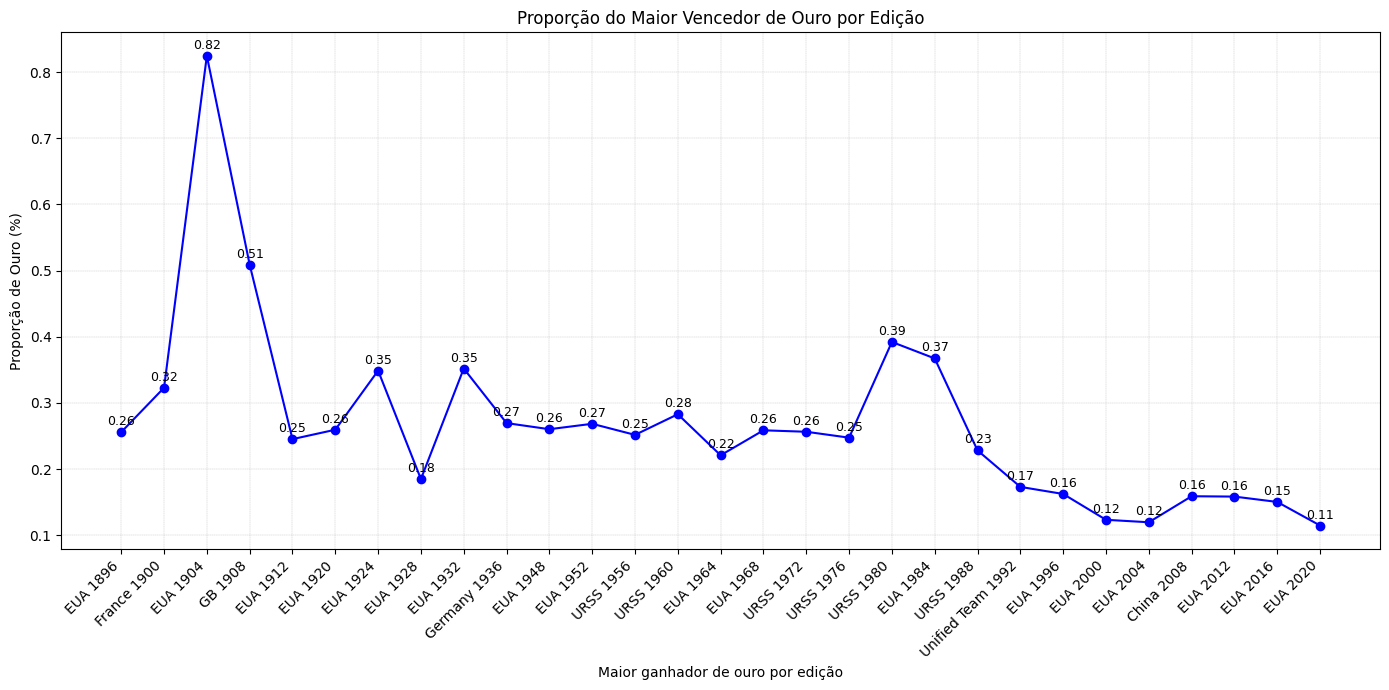

In [15]:
# Executar a consulta
query = """
    WITH EDIÇÃO_TOTAL AS (
        SELECT  
            EDITION,
            YEAR,
            SUM(GOLD) AS TOTAL_GOLD
        FROM 
            country_medals_tally
        WHERE 
            EDITION LIKE '%Summer%'
            AND YEAR <= 2024
        GROUP BY 
            EDITION, YEAR
    ),
    PROPORÇÕES AS (
        SELECT  
            TALLY.COUNTRY,
            TALLY.EDITION,
            TALLY.YEAR,
            SUM(TALLY.GOLD) AS GOLD_TOTAL,
            TOTAL.TOTAL_GOLD,
            (SUM(TALLY.GOLD) * 1.0 / TOTAL.TOTAL_GOLD) AS PROPORTION
        FROM 
            country_medals_tally TALLY
        JOIN 
            EDIÇÃO_TOTAL TOTAL
        ON 
            TALLY.EDITION = TOTAL.EDITION
            AND TALLY.YEAR = TOTAL.YEAR
        WHERE 
            TALLY.EDITION LIKE '%Summer%'
            AND TALLY.YEAR <= 2024
        GROUP BY 
            TALLY.COUNTRY, TALLY.EDITION, TALLY.YEAR, TOTAL.TOTAL_GOLD
    ),
    MELHORES_PROPORÇÕES AS (
        SELECT
            EDITION,
            YEAR,
            COUNTRY,
            GOLD_TOTAL,
            TOTAL_GOLD,
            PROPORTION,
            ROW_NUMBER() OVER(PARTITION BY EDITION, YEAR ORDER BY PROPORTION DESC) AS RANK
        FROM 
            PROPORÇÕES
    )
    SELECT  
        COUNTRY,
        EDITION,
        YEAR,
        GOLD_TOTAL AS MEDALHAS_DE_OURO,
        TOTAL_GOLD AS TOTAL_DE_OUROS_EDICAO,
        PROPORTION
    FROM 
        MELHORES_PROPORÇÕES
    WHERE 
        RANK = 1
    ORDER BY 
        YEAR, EDITION;
"""

df_query = pd.read_sql(query, con=engine)

# Substituir nomes dos países
df_query['COUNTRY'] = df_query['COUNTRY'].replace({
    'Soviet Union': 'URSS',
    'United States': 'EUA',
    'People\'s Republic of China': 'China',
    'Great Britain': 'GB'
})

# Criar uma coluna combinando COUNTRY e YEAR para o eixo x
df_query['Edição_Year'] = df_query['COUNTRY'] + ' ' + df_query['YEAR'].astype(str)

# Plotar o gráfico
plt.figure(figsize=(14, 7))
plt.plot(df_query['Edição_Year'], df_query['PROPORTION'], marker='o', linestyle='-', color='b')

# Adicionar anotações com os valores da proporção
for i, row in df_query.iterrows():
    plt.annotate(
        f"{row['PROPORTION']:.2f}", 
        (row['Edição_Year'], row['PROPORTION']),
        textcoords="offset points", 
        xytext=(0,5), 
        ha='center',
        fontsize=9
    )

plt.xticks(rotation=90)
plt.xlabel('Maior ganhador de ouro por edição')
plt.ylabel('Proporção de Ouro (%)')
plt.title('Proporção do Maior Vencedor de Ouro por Edição')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(linestyle='--', lw=0.25)
plt.show()

#### 2.2 POR MODALIDADES

#### Dos 10 países com mais medalhas no quadro geral, qual esporte mais ganhou medalhas de cada país e qual a proporção desse esporte sobre todas as medalhas?

In [16]:
query = """
WITH TopCountries AS (
    SELECT  
        COUNTRY, 
        SUM(TOTAL) AS total_medals
    FROM 
        country_medals_tally 
    WHERE 
        EDITION LIKE '%Summer%'
        AND YEAR <= 2024
    GROUP BY COUNTRY
    ORDER BY total_medals DESC
    LIMIT 10
),
MedalsBySport AS (
    SELECT
        c.country AS athlete_country, 
        r.sport, 
        COUNT(r.medal) AS medals,
        ROW_NUMBER() OVER (PARTITION BY c.country ORDER BY COUNT(r.medal) DESC) AS row_num
    FROM 
        athletes_results AS r
    LEFT JOIN sports_descriptions AS d
        ON r.RESULT_ID = d.RESULT_ID
    LEFT JOIN olympics_editions AS e
        ON e.edition_id = r.edition_id
    LEFT JOIN countries c
        ON c.noc = r.country_noc
    WHERE r.medal IS NOT NULL
        AND e.EDITION LIKE '%Summer%'
        AND e.YEAR <= 2024
        AND c.country IN (SELECT COUNTRY FROM TopCountries)
    GROUP BY c.country, r.sport
)
    SELECT 
        t.COUNTRY AS athlete_country,
        m.sport, 
        m.medals,
        t.total_medals,
        ROUND(1.0 * m.medals/t.total_medals,2) as proportion
    FROM MedalsBySport m
    JOIN TopCountries t
        ON m.athlete_country = t.COUNTRY
    WHERE m.row_num = 1
    ORDER BY t.total_medals DESC;
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete_country,sport,medals,total_medals,proportion
0,United States,Athletics,1234,2655,0.46
1,Soviet Union,Artistic Gymnastics,288,1010,0.29
2,Great Britain,Athletics,408,927,0.44
3,Germany,Rowing,259,791,0.33
4,France,Fencing,318,773,0.41
5,People's Republic of China,Artistic Gymnastics,120,636,0.19
6,Italy,Fencing,381,629,0.61
7,Australia,Swimming,454,541,0.84
8,Hungary,Fencing,242,515,0.47
9,Sweden,Shooting,124,504,0.25


#### Quais modalidades tiveram mais categorias disputadas em Tóquio 2020?

In [20]:
query = """
WITH total_categories AS (
    SELECT COUNT(r.event) AS total_gold_medals
    FROM athletes_results r
    LEFT JOIN olympics_editions AS e
        ON e.edition_id = r.edition_id
    WHERE r.medal IS NOT NULL
        AND e.EDITION LIKE '%Summer%'
        AND e.YEAR <= 2024
),
medals_by_sport AS (
    SELECT  
        r.sport, 
        COUNT(r.event) AS qty_categories
    FROM 
        athletes_results AS r
    LEFT JOIN sports_descriptions AS d
        ON r.RESULT_ID = d.RESULT_ID
    LEFT JOIN olympics_editions AS e
        ON e.edition_id = r.edition_id
    WHERE r.medal IS NOT NULL
        AND e.EDITION LIKE '%Summer%'
        AND e.YEAR <= 2020
    GROUP BY r.sport
)
    
    SELECT  
        m.sport, 
        m.qty_categories,
        ROUND(m.qty_categories * 1.0 / t.total_gold_medals, 2) AS proportion
    FROM medals_by_sport m
    JOIN total_categories t
    ON 1=1
    ORDER BY m.qty_categories DESC
    LIMIT 5;

"""
df_query = pd.read_sql(query, con=engine)
df_query

,sport,qty_categories,proportion
0,Athletics,4509,0.12
1,Swimming,3278,0.09
2,Rowing,3074,0.08
3,Artistic Gymnastics,2276,0.06
4,Football,2064,0.06


#### Lembrando que a maioria das modalidades não foram disputadas desde a primeira edição. Ginástica, por exemplo, foi.

#### 2.3 ATLETAS

#### Quais atletas mais ganharam medalhas? Qual seus aproveitamentos sobre suas participações olímpicas?

In [18]:
query = """
WITH TOTAL_PARTICIPATIONS_ATHLETE AS(
    SELECT ATHLETE, COUNT(ATHLETE) AS participations
    FROM athletes_results
    GROUP BY ATHLETE)
    
    SELECT  
        r.athlete,
        r.sport,
        b.sex,
        b.country,
        COUNT(r.medal) as qty_medals,
        p.participations,
        ROUND(1.0 * COUNT(r.medal)/p.participations,2) as [medals over participations]
    FROM athletes_results r
        INNER JOIN athletes_bio b
            ON r.athlete_id = b.athlete_id
        INNER JOIN olympics_editions o
            ON r.edition_id = o.edition_id
        INNER JOIN TOTAL_PARTICIPATIONS_ATHLETE p
            ON p.ATHLETE = r.ATHLETE
    WHERE r.EDITION LIKE '%Summer%'
            AND o.YEAR <= 2024        
    GROUP BY r.athlete, r.sport, b.sex, b.country
    ORDER BY COUNT(r.medal) DESC
    LIMIT 10
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sport,sex,country,qty_medals,participations,medals over participations
0,Michael Phelps,Swimming,Male,United States,28,30,0.93
1,Larisa Latynina,Artistic Gymnastics,Female,Soviet Union,18,19,0.95
2,Nikolay Andrianov,Artistic Gymnastics,Male,Soviet Union,15,24,0.63
3,Boris Shakhlin,Artistic Gymnastics,Male,Soviet Union Ukraine,13,24,0.54
4,Edoardo Mangiarotti,Fencing,Male,Italy,13,14,0.93
5,Takashi Ono,Artistic Gymnastics,Male,Japan,13,33,0.39
6,Aleksey Nemov,Artistic Gymnastics,Male,Russian Federation,12,21,0.57
7,Dara Torres,Swimming,Female,United States,12,13,0.92
8,Isabell Werth,Equestrian Dressage,Female,Germany,12,12,1.00
9,Jenny Thompson,Swimming,Female,United States,12,19,0.63


#### Quais atletas mais ganharam medalhas de ouro na história? Qual o aproveitamento deles em relação à todas as participações olímpicas que tiveram?

In [34]:
query = """
WITH TOTAL_PARTICIPATIONS_ATHLETE AS(
    SELECT ATHLETE, COUNT(ATHLETE) AS participations
    FROM athletes_results
    GROUP BY ATHLETE)
    
SELECT  
    r.athlete,
    r.sport,
    b.sex,
    b.country,
    COUNT(r.medal) as qty_golds,
    t.participations,
    1.0 * COUNT(r.medal)/t.participations AS proportion
FROM athletes_results r
    INNER JOIN athletes_bio b
        ON r.athlete_id = b.athlete_id
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
    INNER JOIN TOTAL_PARTICIPATIONS_ATHLETE t
        ON t.athlete = r.athlete
WHERE r.EDITION LIKE '%Summer%'
        AND o.YEAR <= 2024  
        AND r.medal = 'Gold'
GROUP BY r.athlete, r.sport, b.sex, b.country
ORDER BY COUNT(r.medal) DESC
LIMIT 10
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sport,sex,country,qty_golds,participations,proportion
0,Michael Phelps,Swimming,Male,United States,23,30,0.766667
1,Carl Lewis,Athletics,Male,United States,9,10,0.900000
2,Larisa Latynina,Artistic Gymnastics,Female,Soviet Union,9,19,0.473684
3,Mark Spitz,Swimming,Male,United States,9,12,0.750000
4,Paavo Nurmi,Athletics,Male,Finland,9,15,0.600000
5,Jenny Thompson,Swimming,Female,United States,8,19,0.421053
6,Matt Biondi,Swimming,Male,United States,8,12,0.666667
7,Ray Ewry,Athletics,Male,United States,8,9,0.888889
8,Sawao Kato,Artistic Gymnastics,Male,Japan,8,24,0.333333
9,Usain Bolt,Athletics,Male,Jamaica,8,10,0.800000


#### Quais atletas que competiram mais de 5x tiveram melhor aproveitamento em medalhas de ouro sobre todas as provas que competiram?

In [83]:
query = """
WITH TOTAL_MEDALS_ATHLETE AS(
    SELECT ATHLETE, COUNT(ATHLETE) AS participations
    FROM athletes_results
    GROUP BY ATHLETE)
    
SELECT  
    r.athlete,
    r.sport,
    b.sex,
    b.country,
    COUNT(r.medal) as qty_golds,
    t.participations,
    ROUND(1.0 * COUNT(r.medal)/t.participations,2) AS efficiency
FROM athletes_results r
    INNER JOIN athletes_bio b
        ON r.athlete_id = b.athlete_id
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
    INNER JOIN TOTAL_MEDALS_ATHLETE t
        ON r.athlete = t.athlete
WHERE r.EDITION LIKE '%Summer%'
        AND o.YEAR <= 2024  
        AND r.MEDAL = 'Gold'
GROUP BY r.athlete, r.sport, b.sex, b.country
HAVING COUNT(r.medal) > 5
ORDER BY efficiency DESC
LIMIT 10
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sport,sex,country,qty_golds,participations,efficiency
0,Kristin Otto,Swimming,Female,East Germany,6,6,1.00
1,Svetlana Romashina,Artistic Swimming,Female,ROC Russian Federation,7,7,1.00
2,Carl Lewis,Athletics,Male,United States,9,10,0.90
3,Ray Ewry,Athletics,Male,United States,8,9,0.89
4,Don Schollander,Swimming,Male,United States,7,8,0.88
5,Rudolf Kárpáti,Fencing,Male,Hungary,6,7,0.86
6,Usain Bolt,Athletics,Male,Jamaica,8,10,0.80
7,Caeleb Dressel,Swimming,Male,United States,7,9,0.78
8,Michael Phelps,Swimming,Male,United States,23,30,0.77
9,Amy Van Dyken,Swimming,Female,United States,6,8,0.75


#### Quais atletas ganharam mais ouro em uma edição olímpica?

In [15]:
query = """ 
SELECT  
    r.ATHLETE,
    r.SPORT,
    b.COUNTRY,
    o.YEAR,
    o.CITY,
    COUNT(r.MEDAL) as qty_gold
FROM athletes_results r
    INNER JOIN athletes_bio b
        ON r.athlete_id = b.athlete_id
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
WHERE r.EDITION LIKE '%Summer%'
        AND o.YEAR <= 2024  
        AND r.MEDAL = 'Gold'
GROUP BY     r.ATHLETE, r.SPORT, b.COUNTRY, o.YEAR, o.CITY
ORDER BY COUNT(MEDAL) DESC
LIMIT 5
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sport,country,year,city,qty_gold
0,Michael Phelps,Swimming,United States,2008,Beijing,8
1,Mark Spitz,Swimming,United States,1972,München,7
2,Kristin Otto,Swimming,East Germany,1988,Seoul,6
3,Michael Phelps,Swimming,United States,2004,Athina,6
4,Vitali Shcherba,Artistic Gymnastics,Belarus Unified Team,1992,Barcelona,6
5,Anton Heida,Artistic Gymnastics,United States,1904,St. Louis,5
6,Caeleb Dressel,Swimming,United States,2020,Tokyo,5
7,Matt Biondi,Swimming,United States,1988,Seoul,5


#### Quais esportes têm maior média de altura?

In [84]:
query = """ 
SELECT  
    r.sport,
    AVG(b.height) as avg_height
FROM athletes_results r
    INNER JOIN athletes_bio b
        ON r.athlete_id = b.athlete_id
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
WHERE r.EDITION LIKE '%Summer%'
        AND o.YEAR <= 2024  
        AND r.MEDAL = 'Gold'
        AND b.height IS NOT NULL
        AND b.height != "None"
GROUP BY r.sport
ORDER BY avg_height DESC
LIMIT 5
"""
df_query = pd.read_sql(query, con=engine)
df_query

,sport,avg_height
0,Basketball,192.856021
1,3x3 Basketball,189.500000
2,Beach Volleyball,188.392857
3,Volleyball,187.058309
4,Water Polo,186.353741


#### Qual atleta mais jovem a ser medalhista olímpico?

In [35]:
query = """ 
SELECT  
    r.athlete,
    r.sport,
    r.event,
    o.year,
    b.born
FROM athletes_results r
    INNER JOIN athletes_bio b
        ON r.athlete_id = b.athlete_id
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
WHERE r.EDITION LIKE '%Summer%'
        AND o.YEAR <= 2024  
        AND r.MEDAL = 'Gold'
LIMIT 5
"""

# Extrair dados para um DataFrame
df_query = pd.read_sql(query, con=engine)

# Converter a coluna 'born' para datetime
df_query['born'] = pd.to_datetime(df_query['born'], format='%d %B %Y')

df_query.to_sql('athletes_bio_update', con=engine, if_exists='replace', index=False)

5

In [36]:
query = """ 
SELECT  
    r.athlete,
    b.sex,
    c.country,
    r.sport,
    r.event,
    r.medal,
    o.year,
    o.formatted_start_date,
    b.born,
    o.formatted_start_date - b.born AS age
FROM athletes_results r
    INNER JOIN athletes_bio b
        ON r.athlete_id = b.athlete_id
    INNER JOIN olympics_editions o
        ON r.edition_id = o.edition_id
    INNER JOIN countries c
        ON c.noc = r.country_noc
WHERE r.EDITION LIKE '%Summer%'
        AND o.YEAR <= 2024  
        AND r.MEDAL != 'None'
        AND b.born != 'None'
ORDER BY age ASC
LIMIT 5
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sex,country,sport,event,medal,year,formatted_start_date,born,age
0,Paul Piaget,Male,Switzerland,Rowing,"Coxed Pairs, Men",Bronze,1920,1920-08-14,1905,15
1,Ioannis Malokinis,Male,Greece,Swimming,"100 metres Freestyle For Sailors, Men",Gold,1896,1896-04-06,1880,16
2,Petros Persakis,Male,Greece,Artistic Gymnastics,"Parallel Bars, Teams, Men",Silver,1896,1896-04-06,1879,17
3,Petros Persakis,Male,Greece,Artistic Gymnastics,"Rings, Men",Bronze,1896,1896-04-06,1879,17
4,Eugen Sfetescu,Male,Romania,Rugby,"Rugby, Men",Bronze,1924,1924-07-05,1907,17


### Quais atletas de modalidades coletivas tiveram melhor aproveitamento em medalhas de ouro?

In [37]:
query = """
    SELECT r.ATHLETE, b.SEX, r.COUNTRY_NOC, r.SPORT, COUNT(r.MEDAL) AS qty_gold
    FROM athletes_results r
        INNER JOIN athletes_bio b
            ON r.athlete_id = b.athlete_id
    WHERE isteamsport = 1 
            AND medal='Gold'
            AND EDITION LIKE '%Summer%'
            AND SPORT NOT IN ('Swimming','Athletics','Equestrian Dressage','Artistic Swimming','Fencing','Rowing','Shooting','Canoe Sprint','Diving')
    GROUP BY r.ATHLETE, b.sex, r.SPORT, r.COUNTRY_NOC
    ORDER BY COUNT(r.MEDAL) DESC
    LIMIT 10
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sex,country_noc,sport,qty_gold
0,Diana Taurasi,Female,USA,Basketball,5
1,Sue Bird,Female,USA,Basketball,5
2,Lisa Leslie,Female,USA,Basketball,4
3,Sylvia Fowles,Female,USA,Basketball,4
4,Tamika Catchings,Female,USA,Basketball,4
5,Teresa Edwards,Female,USA,Basketball,4
6,Ana Ivis Fernández,Female,CUB,Volleyball,3
7,Andrew Hoy,Male,AUS,Equestrian Eventing,3
8,"Balbir Singh, Sr.",Male,IND,Hockey,3
9,Carmelo Anthony,Male,USA,Basketball,3


Tirei alguns esportes individuais que tinham categorias coletivas como natação, ginástica, tiro ao alvo, vela, etc. Até ficar apenas esportes coletivos

## 3. BRASIL NAS OLIMPÍADAS

Quais esportes o Brasil mais foi medalhista?

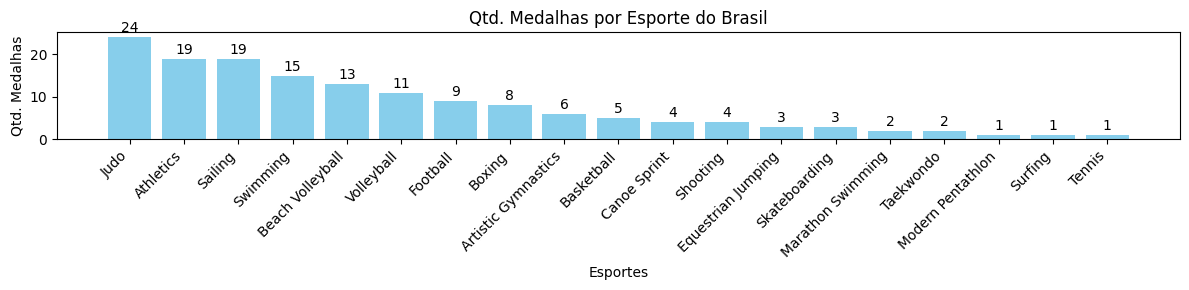

In [152]:
query = """
WITH MedalCounts AS (
    SELECT
        R.sport,
        R.event,
        CAST(SUBSTRING(R.edition, 1, 4) AS INTEGER) AS year,
        COUNT(DISTINCT R.medal) AS medal_count
    FROM athletes_results R
    WHERE R.medal != 'None'
          AND R.country_noc = 'BRA'
          AND R.edition LIKE '%Summer%'
    GROUP BY R.sport, R.event, CAST(SUBSTRING(R.edition, 1, 4) AS INTEGER)
),
DistinctSportMedals AS (
    SELECT
        sport,
        SUM(medal_count) AS total_medals
    FROM MedalCounts
    GROUP BY sport
)
SELECT
    sport,
    total_medals
FROM DistinctSportMedals
ORDER BY total_medals DESC;
"""
df_query = pd.read_sql(query, con=engine)

plt.figure(figsize=(12, 3))
bars=plt.bar(df_query['sport'], df_query['total_medals'], color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  
        yval + 0.5, 
        int(yval),  
        ha='center',  
        va='bottom'   
    )
plt.xlabel('Esportes')
plt.ylabel('Qtd. Medalhas')
plt.title('Qtd. Medalhas por Esporte do Brasil')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### E de ouro?

In [153]:
query = """
WITH MedalCounts AS (
    SELECT
        R.sport,
        R.event,
        CAST(SUBSTRING(R.edition, 1, 4) AS INTEGER) AS year,
        COUNT(DISTINCT R.medal) AS medal_count
    FROM athletes_results R
    WHERE R.medal = 'Gold'
          AND R.country_noc = 'BRA'
          AND R.edition LIKE '%Summer%'
    GROUP BY R.sport, R.event, CAST(SUBSTRING(R.edition, 1, 4) AS INTEGER)
),
DistinctSportMedals AS (
    SELECT
        sport,
        SUM(medal_count) AS total_medals
    FROM MedalCounts
    GROUP BY sport
)
SELECT
    sport,
    total_medals
FROM DistinctSportMedals
ORDER BY total_medals DESC;
"""
df_query = pd.read_sql(query, con=engine)
df_query

,sport,total_medals
0,Sailing,8
1,Athletics,5
2,Volleyball,5
3,Judo,4
4,Beach Volleyball,3
5,Artistic Gymnastics,2
6,Boxing,2
7,Football,2
8,Canoe Sprint,1
9,Equestrian Jumping,1


### Quais atletas mais ganharam medalhas?

In [161]:
query = """
SELECT 
    athlete,
    sport,
    COUNT(*) AS total_medals
FROM 
    athletes_results
WHERE 
    country_noc = 'BRA'
    AND medal != 'None'
    AND CAST(SUBSTRING(edition, 1, 4) AS INTEGER) <= 2024
    AND edition LIKE '%Summer%'
GROUP BY 
    athlete, sport
ORDER BY 
    total_medals DESC
LIMIT 5
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sport,total_medals
0,Robert Scheidt,Sailing,5
1,Torben Grael,Sailing,5
2,Serginho,Volleyball,4
3,Gustavo Borges,Swimming,4
4,Isaquias Queiroz,Canoe Sprint,4


#### Quais atletas mais ganharam medalhas de ouro?

In [39]:
query = """
SELECT 
    athlete,
    sport,
    COUNT(*) AS qty_gold
FROM 
    athletes_results
WHERE 
    country_noc = 'BRA'
    AND medal = 'Gold'
    AND CAST(SUBSTRING(edition, 1, 4) AS INTEGER) <= 2024
    AND edition LIKE '%Summer%'
GROUP BY 
    athlete, sport
ORDER BY 
    qty_gold DESC
LIMIT 5
"""
df_query = pd.read_sql(query, con=engine)
df_query

,athlete,sport,qty_gold
0,Fabi,Volleyball,2
1,Fabiana,Volleyball,2
2,Giovane,Volleyball,2
3,Jaque,Volleyball,2
4,Luan,Football,2


____________________________________________________________________________________________________________________

## CONCLUSÃO:
- Estamos na 33ª Olimpíada de Verão
- O atletismo foi o esporte com mais provas em Tóquio 2020
- Londres é a cidade que mais sediou Olimpíadas: 1908, 1944, 1948 e 2012
- A edição mais longa foi em Londres (1900), que durou 6 meses. Após 1948, as Olimpíadas têm duração média de 17 dias, com pouca variância
- Na segunda edição, Paris 1900, alguns esportes que hoje não são mais olímpicos foram disputados: corrida de carros e barcos, balonismo, combate à incêndios, pesca, salvamento de vidas, exercício militar, cabo de guerra, entre diversos outros. Muitos desses foram classificados como não oficiais, pelo regulamento esportivo na época não ser muito elaborado e pelo interesse de atrair o interesse do público e demonstrar inovação/poder dos países. Esses esportes não oficiais não premiaram com medalhas.
- O EUA é o país com mais ouros na história, e também o país líder no quadro geral em 18 edições. O maior destaque do EUA foi em 1904, onde ganharam 80 dos 97 ouros da edição (82%). O esporte que mais deu medalhas aos EUA é o atletismo, com aproximadamente 30% de todas as medalhas.
- O segundo país com mais ouros é a URSS, que terminou 6 edições olímpicas como o líder do quadro de medalhas. O esporte que mais deu medalhas à URSS foi a ginástica.
- Michael Phelps (natação) foi o maior campeão olímpico, com 23 ouros. Ele disputou 30 provas, das quais ficou no pódio em 28 (93%). Também, ele é o atleta com mais ouros numa única edição: 8 em Pequim 2008.
- O medalhista olímpico mais jovem foi o suíço Paul Piaget, que ganhou um bronze no remo em 1920.
- As maiores campeãs olímpicas de esportes coletivos, em ambos os gêneros, são duas estadunidenses do basquete, com 5 ouros.
- Do Brasil, os esportes com mais medalhas são judô, atletismo e vela, respectivamente. Robert Scheidt e Torben Grael, ambos da vela, são os maiores medalhistas do brasil, com 5 medalhas cada. Os maiores campeões brasileiros têm 2 medalhas, Fabi, Fabiana, Sheilla, Giovane e Serginho são alguns deles.

____________________________________________________________________________________________________________________